# What is Chat model
A chat model is a language model(LLM) that uses chat messages as input and return chat messages as output.
This is a specialized type of LLM designed for converstational interaction. It is trained on conversational data and is able to understand and respond to prompts in a way that simalates human converstion.
Note: All chat models are LLM not all LLM are chat models.

# Messages
Definition: Messages are pieces of information or data objects exchanged between nodes in the graph. 
# State
Definition: State is the shared context or memory that persists across the execution of the graph. It stores information that nodes in the graph can read from or write to.


# Reducer Function
A **reducer function** is a function that defines how to update a state value when new data is added. For example, instead of replacing the entire value, it can append new data to the existing state.

### Simplest Example
Suppose we have a list of messages:

#### Initial State:
```python
messages = ["Hello!", "How are you?"]
```

#### New Message:
```python
new_message = "I'm fine, thank you!"
```

#### Reducer Function:
A reducer function appends the new message instead of overwriting the list:

```python
def add_messages(current_messages, new_message):
    return current_messages + [new_message]

# Update state
messages = add_messages(messages, new_message)

print(messages)
```

#### Output:
```plaintext
["Hello!", "How are you?", "I'm fine, thank you!"]
```

This ensures the new message is added to the existing list, not replacing it.

## Reducers

Now, we have a minor problem!

As we discussed, each node will return a new value for our state key `messages`.

But, this new value will [will override](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) the prior `messages` value.

As our graph runs, we want to **append** messages to to our `messages` state key.

We can use [reducer functions](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) address this.

Reducers allow us to specify how state updates are performed.

If no reducer function is specified, then it is assumed that updates to the key should *override it* as we saw before.

But, to append messages, we can use the pre-built `add_messages` reducer.

This ensures that any messages are appended to the existing list of messages.

We annotate simply need to annotate our `messages` key with the `add_messages` reducer function as metadata.

Since having a list of messages in graph state is so common, LangGraph has a pre-built [`MessagesState`](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate)!

`MessagesState` is defined:

* With a pre-build single `messages` key
* This is a list of `AnyMessage` objects
* It uses the `add_messages` reducer

We'll usually use `MessagesState` because it is less verbose than defining a custom `TypedDict`, as shown above.

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage
class MessageState(TypedDict):
    messages: Annotated[list[AnyMessages,add_messages]]  # Add any keys needed beyond messages, which is pre-built

In [6]:
from langchain_core.messages import AIMessage,HumanMessage
from langgraph.graph.message import add_messages
our_messages = [HumanMessage(content="What is AI stand for ?", name="arman"),
    AIMessage(content="AI stand for Artificial Inteligince",name = "model")]
new_message = HumanMessage(content ="AI is easy or hard ?")
final_result = add_messages(our_messages,new_message)

In [7]:
final_result

[HumanMessage(content='What is AI stand for ?', additional_kwargs={}, response_metadata={}, name='arman', id='e530c7c0-1f89-499e-9dcb-0cb2d0b72c47'),
 AIMessage(content='AI stand for Artificial Inteligince', additional_kwargs={}, response_metadata={}, name='model', id='d4142a2d-5341-4450-8a4a-deedeafa8d9c'),
 HumanMessage(content='AI is easy or hard ?', additional_kwargs={}, response_metadata={}, id='060f69ac-08e0-4aa6-a86f-13f413efef48')]

In [11]:
def multiply(num1:float,num2:float)->int:
    """
    Multiply of two numbers like num1 and num2
    Args:
    num1:first float,
    num2:second float
"""
    return num1 * num2

def add(num1:float,num2:float)->int:
    """
    Add two numbers like num1 and num2 
    Args:
    num1:first float,
    num2:second float
    """
    return num1 + num2

In [13]:
import os
from dotenv import load_dotenv
load_dotenv()

GEMINI_API_KEY = os.getenv( "GEMINI_API_KEY")
if not GEMINI_API_KEY:
    raise valueError("GEMINI_API_KEY is not set in the .env file please write api key and proceed further")
print("GEMINI_API_KEY is loaded successfully")
    

GEMINI_API_KEY is loaded successfully


In [14]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(api_key = GEMINI_API_KEY,model='gemini-1.5-flash',temperature=0.2)
llm_invoke=llm.invoke("hi")
print(llm_invoke)

content='Hi there! How can I help you today?\n' additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []} id='run-051cb572-6224-4ca4-9ff6-0ed440de6fdc-0' usage_metadata={'input_tokens': 2, 'output_tokens': 11, 'total_tokens': 13, 'input_token_details': {'cache_read': 0}}


In [22]:
llm_with_tools = llm.bind_tools([multiply,add])
calling_llm_with_tools = llm_with_tools.invoke("multiply 333 with 4 and then add  3 ")
print(calling_llm_with_tools)

content='' additional_kwargs={'function_call': {'name': 'add', 'arguments': '{"num2": 3.0, "num1": 1332.0}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []} id='run-fe4f840c-5a04-4e56-9146-2ef8b118e768-0' tool_calls=[{'name': 'multiply', 'args': {'num2': 4.0, 'num1': 333.0}, 'id': '3f11d508-1d95-4266-a646-ecbcc34ace88', 'type': 'tool_call'}, {'name': 'add', 'args': {'num2': 3.0, 'num1': 1332.0}, 'id': 'f3e22569-a8ba-4b45-a2ae-2ca42df263af', 'type': 'tool_call'}] usage_metadata={'input_tokens': 157, 'output_tokens': 10, 'total_tokens': 167, 'input_token_details': {'cache_read': 0}}


In [55]:
from langgraph.graph import StateGraph, START,END,MessagesState 

def fun_llm_calls(msg:MessagesState):
    return {"messages":[llm_with_tools.invoke(msg["messages"])]}
   

starting_graph:StateGraph = StateGraph(MessagesState)
starting_graph.add_node("Node_1",fun_llm_calls)
starting_graph.add_edge(START, 'Node_1')
starting_graph.add_edge('Node_1' ,END)
graph_compling = starting_graph.compile()

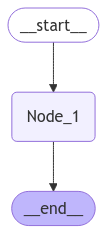

In [56]:
from IPython.display import display,Image
display(Image(graph_compling.get_graph().draw_mermaid_png()))
 

In [ ]:
result = graph_compling.invoke({"messages": HumanMessage(content="Hello! how are you")})
for m in result["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hello! How can I help you today?


In [62]:
messages = graph_compling.invoke({"messages": HumanMessage(content="multiply 333 with 4 and then add  3")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

multiply 333 with 4 and then add  3
================================== Ai Message ==================================
Tool Calls:
  multiply (e4fe8658-2447-4462-b595-1f5794a6e3b5)
 Call ID: e4fe8658-2447-4462-b595-1f5794a6e3b5
  Args:
    num2: 4.0
    num1: 333.0
  add (506c77f2-821b-4adf-9452-248ae2ff3211)
 Call ID: 506c77f2-821b-4adf-9452-248ae2ff3211
  Args:
    num2: 3.0
    num1: 1332.0
